# Engineering of Data Analysis: assignment 2

By delivering this notebook, we confirm that the code presented was developed by the following students.

**Student num:****; Name:** 

**Student num:****; Name:** 

**DEADLINE:** 13th May, 23h59

**Only one student should deliver the notebook in a ZIP file that includes the dataset for exercise 4**
**The notebook shoud have all outputs present**


Some useful links:
* [ACM DEBS 2015 Grand Challenge](http://www.debs2015.org/call-grand-challenge.html)

* [Spark web site](https://spark.apache.org/)

* [Anonymity_api](https://github.com/farosilva0/anonymity_api)

* [IBM differential privacy library](https://github.com/IBM/differential-privacy-library)


# Install software

In [ ]:
# Install Spark
!apt-get install openjdk-17-jdk-headless
!pip install pyspark==4.0.0.dev2
!mkdir checkpoint


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  openjdk-17-jre-headless
Suggested packages:
  openjdk-17-demo openjdk-17-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  | fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-17-jdk-headless openjdk-17-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 120 MB of archives.
After this operation, 272 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 openjdk-17-jre-headless amd64 17.0.15+6~us1-0ubuntu1~22.04 [48.3 MB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 openjdk-17-jdk-headless amd64 17.0.15+6~us1-0ubuntu1~22.04 [71.3 MB]
Fetched 120 MB in 6s (19.1 MB/s)
Selecting previously unselected package openjdk-17-jre-headless:amd64.
(Re

In [1]:
!pip install anonymity-api==1.0.4
!pip install diffprivlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.9/176.9 kB 3.7 MB/s eta 0:00:00


In [ ]:
# Set and validate that CuDF can use the CUDA-capable GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # Gives CuDF access to Google Colab GPU
print(os.environ.get('CUDA_VISIBLE_DEVICES'))

0


# Setup

The data sets are available in the following link: https://drive.google.com/drive/folders/1WMwLUj0t4Q0GSll96lbF2bDjaPVh1w8z?usp=sharing (the same as in assignment 1). For running in Google Colab, you should access the link and Add Shortcut to your Drive.



In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# If you added the shortcut to your drive, the file should appear in this directory
# If not, you need to explore from directory /content/drive
!ls /content/drive/MyDrive/Engineering_of_Data_Analysis/assignment1


Mounted at /content/drive
adult.csv  Life_Expectancy_Data.csv  sample.csv.gz    sorted_data.csv.gz
heart.csv  sample.csv		     sorted_data.csv  tiny.csv.gz


In [ ]:
# Run this cell only if you are going to run exercise 1
!mkdir data
# Use the cp command to create a copy of the contents of the file sample1.csv
# which is remote on the drive and copy it into a local folder data
!cp /content/drive/MyDrive/Engineering_of_Data_Analysis/assignment1/sample.csv data

Next cells setup: Pandas and Spark.

In [8]:
# General imports
import timeit

import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster

# Anonymization imports
from anonymity_api import anonymity
from anonymity_api import utility

In [ ]:
# Imports for Spark

import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

# imports Spark SQL and Pandas API
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import *
from pyspark.ml.feature import *
import pyspark.pandas as ps

# this sets the maximum number of rows to show when printing pandas Dataframes
ps.set_option('display.max_rows', 10)

/usr/local/lib/python3.11/dist-packages/pyspark/pandas/utils.py:1017: PandasAPIOnSparkAdviceWarning: The config 'spark.sql.ansi.enabled' is set to True. This can cause unexpected behavior from pandas API on Spark since pandas API on Spark follows the behavior of pandas, not SQL.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [ ]:
FILENAME_LOCAL = "data/sample.csv"
FILENAME_RMT = "/content/drive/MyDrive/Engineering_of_Data_Analysis/assignment1/sample.csv"

## Exercise 1: local data files vs. remote data files

Compute the number of distinct licenses, accessing local file and remote file.

Compare the time it takes to execute the code for Pandas, Spark SQL and cuDF for accessing a local file and a remote file.


### Code: Pandas library

In [ ]:
mySchema = ["medallion", "hack_license", "pickup_datetime",
            "dropoff_datetime", "trip_time_in_secs", "trip_distance",
            "pickup_longitude", "pickup_latitude", "dropoff_longitude",
            "dropoff_latitude", "payment_type", "fare_amount",
            "surcharge", "mta_tax", "tip_amount",
            "tolls_amount", "total_amount"]

print( "Local file")
start_time = time.time()

dataset = pd.read_csv(FILENAME_LOCAL,names=mySchema)
result = dataset["hack_license"].nunique()

end_time = time.time()

print( "Runtime = " + str(end_time - start_time))


print( "Remote file")
start_time = time.time()

dataset = pd.read_csv(FILENAME_RMT,names=mySchema)
result = dataset["hack_license"].nunique()

end_time = time.time()

print( "Runtime = " + str(end_time - start_time))

Local file
Runtime = 5.167592525482178
Remote file
Runtime = 7.034967422485352


### Results (Pandas)

The time to process the small dataset, local file, was : **5.16** seconds.

The time to process the small dataset, remote file, was : **7.03** seconds.


### Spark SQL

In [ ]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

mySchema = StructType([
    StructField("medallion", StringType()),
    StructField("hack_license", StringType()),
    StructField("pickup_datetime", TimestampType()),
    StructField("dropoff_datetime", TimestampType()),
    StructField("trip_time_in_secs", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("pickup_longitude", DoubleType()),
    StructField("pickup_latitude", DoubleType()),
    StructField("dropoff_longitude", DoubleType()),
    StructField("dropoff_latitude", DoubleType()),
    StructField("payment_type", StringType()),
    StructField("fare_amount", DoubleType()),
    StructField("surcharge", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("total_amount", DoubleType()),
])

print( "Local file")

start_time = time.time()
dataset = spark.read.load(FILENAME_LOCAL, format="csv",
                         sep=",", schema=mySchema, header="false")
dataset.createOrReplaceTempView("data")
statisticsDF = spark.sql( """SELECT COUNT(DISTINCT hack_license) AS total_amount FROM data""")
statistics = statisticsDF.collect()

end_time = time.time()

print( "Runtime = " + str(end_time - start_time))

print( "Remote file")

start_time = time.time()

dataset = spark.read.load(FILENAME_RMT, format="csv",
                         sep=",", schema=mySchema, header="false")
dataset.createOrReplaceTempView("data")
statisticsDF = spark.sql( """SELECT COUNT(DISTINCT hack_license) AS total_amount FROM data""")
statistics = statisticsDF.collect()

end_time = time.time()

print( "Runtime = " + str(end_time - start_time))


Local file
Runtime = 12.597257137298584
Remote file
Runtime = 6.143192768096924


### Results (Spark)

The time to process the small dataset, local file, was : **12.6** seconds.

The time to process the small dataset, remote file, was : **6.14** seconds.



### Results discussion

### Observations:
- Pandas took only slights longer processing a remote file compared to a local one (7.03 seconds remote vs 5.16 seconds local)
- Spark shows a significantly different behavior, being much slower with a local file than with a remote file (6.14 seconds remote vs 12.6 seconds local). This is the opposite trend observed with Pandas.

### Analysis:

1. **Framework Design and Purpose**
   - Pandas is designed for in-memory data processing with a focus on single-machine performance.
   - Spark is architected for distributed processing and has significant startup overhead for initializing its execution environment.

2. **I/O and Data Processing Patterns**
   - **Pandas**: When processing local files, Pandas has direct file system access with minimal overhead. For remote files, network latency adds a small delay, but the overall processing approach remains the same. The framework is generally fast for a dataset of this size.
   - **Spark**: Spark's architecture is designed for distributed data, allowing it to read chunks of remote files in parallel directly into its executors. This optimized parallel processing read from cloud storage outperforms its handling of local files. Meanwhile, when Spark is run in a local mode (single machine), loading a local file still involves Spark's overhead, so it is relatively slow for a file with a size in the 100s of MBs.

### Practical Implications:
With a small dataset (100s of MBs)...

- ...and local file loading, Pandas shows more predictable and generally faster performance.
- ... and remote file loading, Spark's performance is better than that of Pandas.


## Exercise 2

The goal of this exercise is to compare results obtained with anonymized data and not anonymized. We will use a dataset with information about hear disease.

A quasi-identifier is a set of attributes that, when combined, can lead to the identification of individuals/subjects (Eg. (5-digit ZIP code, birth date, gender) uniquely identify 87% of the population in the U.S.)

The quasi-identifiers are composed by attributes:

    * age - Age of the patient
    * sex - Gender of the patient
    * cp - Type of chest pain
    * trestbps - resting blood pressure
    * chol - cholestoral
    * fbs - fasting blood sugar > 120 mg/dl
    * restecg - resting eletrocardiographic results
    * thalach - Maximum heart rate
    * exang - Exercise induced angina
    * oldpeak - ST depression induced by exercise relative to rest
    * slope - Slope of peak exercise ST segment
    * ca - Number of major vessels colored by fluoroscopy
    * thal - Thalassemia

Sensitive attributes are those that hold sensitive information that should not be revealed as associated to an individual.

The sensitive-attributes are composed by only one attribute:

    * target - 1 if the patient has Hear Disease, otherwise 0

In [ ]:
#Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Engineering_of_Data_Analysis/assignment1/heart.csv')

# List with the quasi-identifiers
qis = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

# List with the sensitive attributes
sas = ['target']


Now, let's anonymize the dataset with library anonimity_lib.

In [ ]:
# the library can automatically suggest an anonymization without the need for providing parameters
anon_df = anonymity.suggest_anonymity( df, qis, sas)

# processing information after generalization is not very simple
# the following function generate random value that keep the average inside each group
# used for anonymity
anon_gen_df = utility.generalize_intervals(anon_df, qis)

Quasi-identifiers
The dataframe has 13 quasi_identifiers, and the number of different values per quasi-identifier is: 
age          41
sex           2
cp            4
trestbps     49
chol        152
fbs           2
restecg       3
thalach      91
exang         2
oldpeak      40
slope         3
ca            5
thal          4
dtype: int64

Sensitive attributes
The dataframe has 1 different values for sensitive attributes and the nuber of different values per attribute is: 
target    2
dtype: int64

Attempting the following anonymizations: 
K-anonymization with k = 4.000000
Utility for k-anonymization: 0.43113462346474324

Distinct l-diversity with l = 2
Utility for distinct l-diversity: 0.42370030536360015

Entropy l-diversity with l = 1.546032
Utility for entropy l-diversity: 0.41509464381280076

Recursive (c,l)-diversity with c = 2 and l = 2
Utility for recursive (c,l)-anonymization: 0.46423403265167634


In [ ]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [ ]:
anon_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,40 - 56,1,0 - 2,110 - 132,167 - 188,0,0 - 1,105 - 123,0 - 1,0.6 - 2.5,1 - 2,0 - 1,1 - 3,0
1,40 - 56,1,0 - 2,110 - 132,167 - 188,0,0 - 1,105 - 123,0 - 1,0.6 - 2.5,1 - 2,0 - 1,1 - 3,0
2,40 - 56,1,0 - 2,110 - 132,167 - 188,0,0 - 1,105 - 123,0 - 1,0.6 - 2.5,1 - 2,0 - 1,1 - 3,1
3,40 - 56,1,0 - 2,110 - 132,167 - 188,0,0 - 1,105 - 123,0 - 1,0.6 - 2.5,1 - 2,0 - 1,1 - 3,0
4,40 - 56,1,0 - 2,110 - 132,167 - 188,0,0 - 1,105 - 123,0 - 1,0.6 - 2.5,1 - 2,0 - 1,1 - 3,0


In [ ]:
anon_gen_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,41,1,1,121,184,0,1,114,0,1,1,0,3,0
1,48,1,0,110,185,0,1,110,1,2,1,1,1,0
2,47,1,0,114,171,0,1,115,1,0,1,1,2,1
3,54,1,2,126,172,0,1,112,0,0,2,0,3,0
4,52,1,0,131,187,0,0,108,0,2,2,1,2,0


Workload-aware anonymization techniques tailor the anonymization perform to the workload that will be run. For knowing more, you can check:

Kristen LeFevre, David J. DeWitt, and Raghu Ramakrishnan. 2006. Workload-aware anonymization. In Proceedings of the 12th ACM SIGKDD international conference on Knowledge discovery and data mining (KDD '06). Association for Computing Machinery, New York, NY, USA, 277–286.
https://pages.cs.wisc.edu/~lefevre/WorkloadAware.pdf

Anonimity_lib supports workload-aware anonymization: https://github.com/farosilva0/anonymity_api


In [ ]:
# for queries based on intervals, you can do the following

anon_groups_df = anonymity.suggest_anonymity_groups( df, qis, sas, queries=['group(age, 20)'])
anon_groups_gen_df = utility.generalize_intervals(anon_groups_df, qis)

Quasi-identifiers
The dataframe has 13 quasi_identifiers, and the number of different values per quasi-identifier is: 
age          7
sex          2
cp           4
trestbps    10
chol        17
fbs          1
restecg      2
thalach     15
exang        2
oldpeak      8
slope        3
ca           2
thal         2
dtype: int64

Sensitive attributes
The dataframe has 1 different values for sensitive attributes and the nuber of different values per attribute is: 
target    2
dtype: int64

Attempting the following anonymizations: 
K-anonymization with k = 2.000000
Utility for k-anonymization: 0.40050894595263686

Distinct l-diversity with l = 2
Utility for distinct l-diversity: 0.541577472420915

Entropy l-diversity with l = 1.482867
Utility for entropy l-diversity: 0.541577472420915

Recursive (c,l)-diversity with c = 3 and l = 2
Utility for recursive (c,l)-anonymization: 0.6478715150866264
Quasi-identifiers
The dataframe has 13 quasi_identifiers, and the number of different values per qua

In [ ]:
anon_groups_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,34 - 40,0 - 1,0 - 3,94 - 118,167 - 199,0,0 - 1,114 - 179,0 - 1,0.0 - 2.0,1 - 2,0,2 - 3,1
1,34 - 40,0 - 1,0 - 3,94 - 118,167 - 199,0,0 - 1,114 - 179,0 - 1,0.0 - 2.0,1 - 2,0,2 - 3,0
2,34 - 40,0 - 1,0 - 3,94 - 118,167 - 199,0,0 - 1,114 - 179,0 - 1,0.0 - 2.0,1 - 2,0,2 - 3,1
3,35,1,0 - 1,120 - 122,192 - 198,0,1,130 - 174,0 - 1,0.0 - 1.6,1 - 2,0,2 - 3,0
4,35,1,0 - 1,120 - 122,192 - 198,0,1,130 - 174,0 - 1,0.0 - 1.6,1 - 2,0,2 - 3,1


In [ ]:
df.value_counts(['age']).sort_index()

,count
age,
29,1
34,2
35,4
37,2
38,3
39,4
40,3
41,10
42,8


In [ ]:
anon_groups_gen_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,34,0,1,115,178,0,0,162,1,1,1,0,3,1
1,34,0,2,116,179,0,0,120,1,0,2,0,2,0
2,37,0,3,99,185,0,0,141,0,0,1,0,2,1
3,35,1,1,120,196,0,1,165,0,0,2,0,2,0
4,35,1,1,120,195,0,1,142,0,1,1,0,2,1


Propose and compte some statistics based on groups/bins, using the original dataset, the anonymized dataset, the workload-aware anonymized dataset and and compare the quality of results.


## 1. Original Dataset Analysis

<ipython-input-14-f33fe13a0f94>:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_stats = df.groupby('age_group')['target'].mean().reset_index()
<ipython-input-14-f33fe13a0f94>:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  chol_stats = df.groupby('chol_group')['target'].mean().reset_index()



Heart Disease Rate by Age Group:
  Age Group  Heart Disease Rate
0     29-34            0.666667
1     35-44            0.754386
2     45-54            0.625000
3     55-64            0.381356
4     65-77            0.515152

Heart Disease Rate by Gender:
  Gender  Heart Disease Rate
0      0            0.750000
1      1            0.449275

Heart Disease Rate by Chest Pain Type:
   Chest Pain Type  Heart Disease Rate
0                0            0.272727
1                1            0.820000
2                2            0.793103
3                3            0.695652

Heart Disease Rate by Cholesterol Level:
  Cholesterol Level  Heart Disease Rate
0            Normal            0.588235
1        Borderline            0.623762
2              High            0.476821


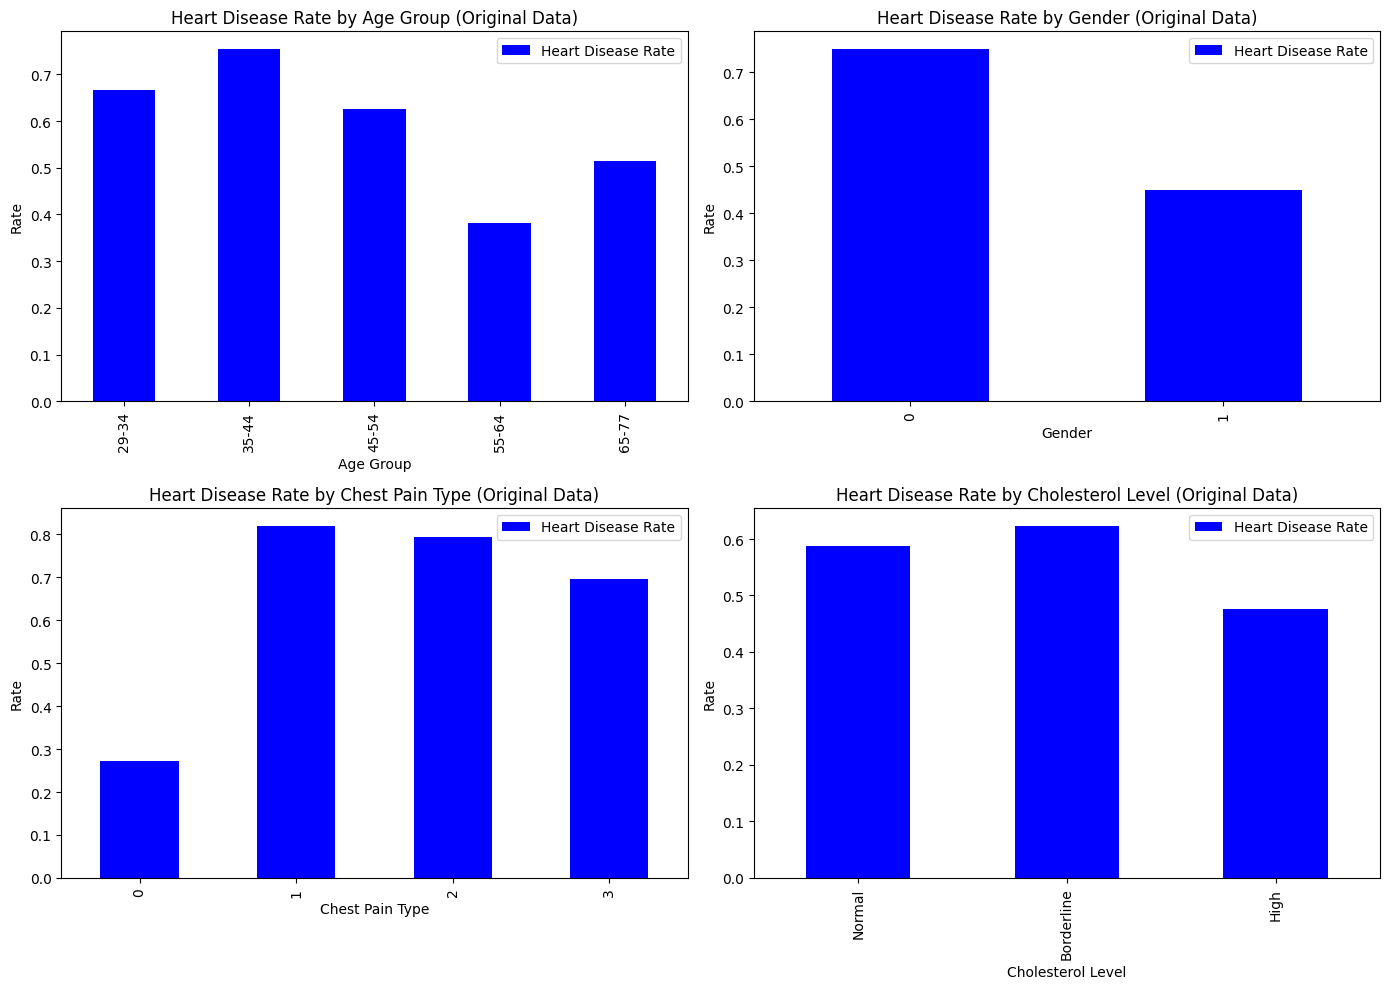

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define group bins and labels
bins = [29, 35, 45, 55, 65, 78]
labels = ['29-34', '35-44', '45-54', '55-64', '65-77']

df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels)
df['chol_group'] = pd.cut(df['chol'], bins=[0, 200, 240, 600], labels=['Normal', 'Borderline', 'High'])

# 1. Heart disease prevalence by age group
age_stats = df.groupby('age_group')['target'].mean().reset_index()
age_stats.columns = ['Age Group', 'Heart Disease Rate']

# 2. By gender
gender_stats = df.groupby('sex')['target'].mean().reset_index()
gender_stats.columns = ['Gender', 'Heart Disease Rate']
gender_stats['Gender'] = gender_stats['Gender'].map({0: '0', 1: '1'})

# 3. By chest pain type
cp_stats = df.groupby('cp')['target'].mean().reset_index()
cp_stats.columns = ['Chest Pain Type', 'Heart Disease Rate']

# 4. By cholesterol level
chol_stats = df.groupby('chol_group')['target'].mean().reset_index()
chol_stats.columns = ['Cholesterol Level', 'Heart Disease Rate']

# Print statistics
print("\nHeart Disease Rate by Age Group:")
print(age_stats)
print("\nHeart Disease Rate by Gender:")
print(gender_stats)
print("\nHeart Disease Rate by Chest Pain Type:")
print(cp_stats)
print("\nHeart Disease Rate by Cholesterol Level:")
print(chol_stats)

# Save for comparison
orig_age_stats = age_stats.copy()
orig_gender_stats = gender_stats.copy()
orig_cp_stats = cp_stats.copy()
orig_chol_stats = chol_stats.copy()

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
age_stats.plot(x='Age Group', y='Heart Disease Rate', kind='bar', ax=axes[0,0], color='blue')
axes[0,0].set_title('Heart Disease Rate by Age Group (Original Data)')
axes[0,0].set_ylabel('Rate')
gender_stats.plot(x='Gender', y='Heart Disease Rate', kind='bar', ax=axes[0,1], color='blue')
axes[0,1].set_title('Heart Disease Rate by Gender (Original Data)')
axes[0,1].set_ylabel('Rate')
cp_stats.plot(x='Chest Pain Type', y='Heart Disease Rate', kind='bar', ax=axes[1,0], color='blue')
axes[1,0].set_title('Heart Disease Rate by Chest Pain Type (Original Data)')
axes[1,0].set_ylabel('Rate')
chol_stats.plot(x='Cholesterol Level', y='Heart Disease Rate', kind='bar', ax=axes[1,1], color='blue')
axes[1,1].set_title('Heart Disease Rate by Cholesterol Level (Original Data)')
axes[1,1].set_ylabel('Rate')
plt.tight_layout()
plt.show()

## 2. Standard Anonymized Dataset Analysis

<ipython-input-15-6466d0f5b63a>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  anon_age_stats = anon_gen_df.groupby('age_group')['target'].mean().reset_index()
<ipython-input-15-6466d0f5b63a>:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  anon_chol_stats = anon_gen_df.groupby('chol_group')['target'].mean().reset_index()



Heart Disease Rate by Age Group:
  Age Group  Heart Disease Rate
0     29-34            1.000000
1     35-44            0.729167
2     45-54            0.541284
3     55-64            0.500000
4     65-77            0.419355

Heart Disease Rate by Gender:
  Gender  Heart Disease Rate
0      0            0.539823
1      1            0.547368

Heart Disease Rate by Chest Pain Type:
   Chest Pain Type  Heart Disease Rate
0                0            0.464912
1                1            0.560976
2                2            0.592593
3                3            0.692308

Heart Disease Rate by Cholesterol Level:
  Cholesterol Level  Heart Disease Rate
0            Normal            0.591837
1        Borderline            0.621359
2              High            0.476821

MAE compared to original data:
Age Group MAE: 0.1313
Gender MAE: 0.1541
Chest Pain Type MAE: 0.1638
Cholesterol Level MAE: 0.0020
Average MAE: 0.1128


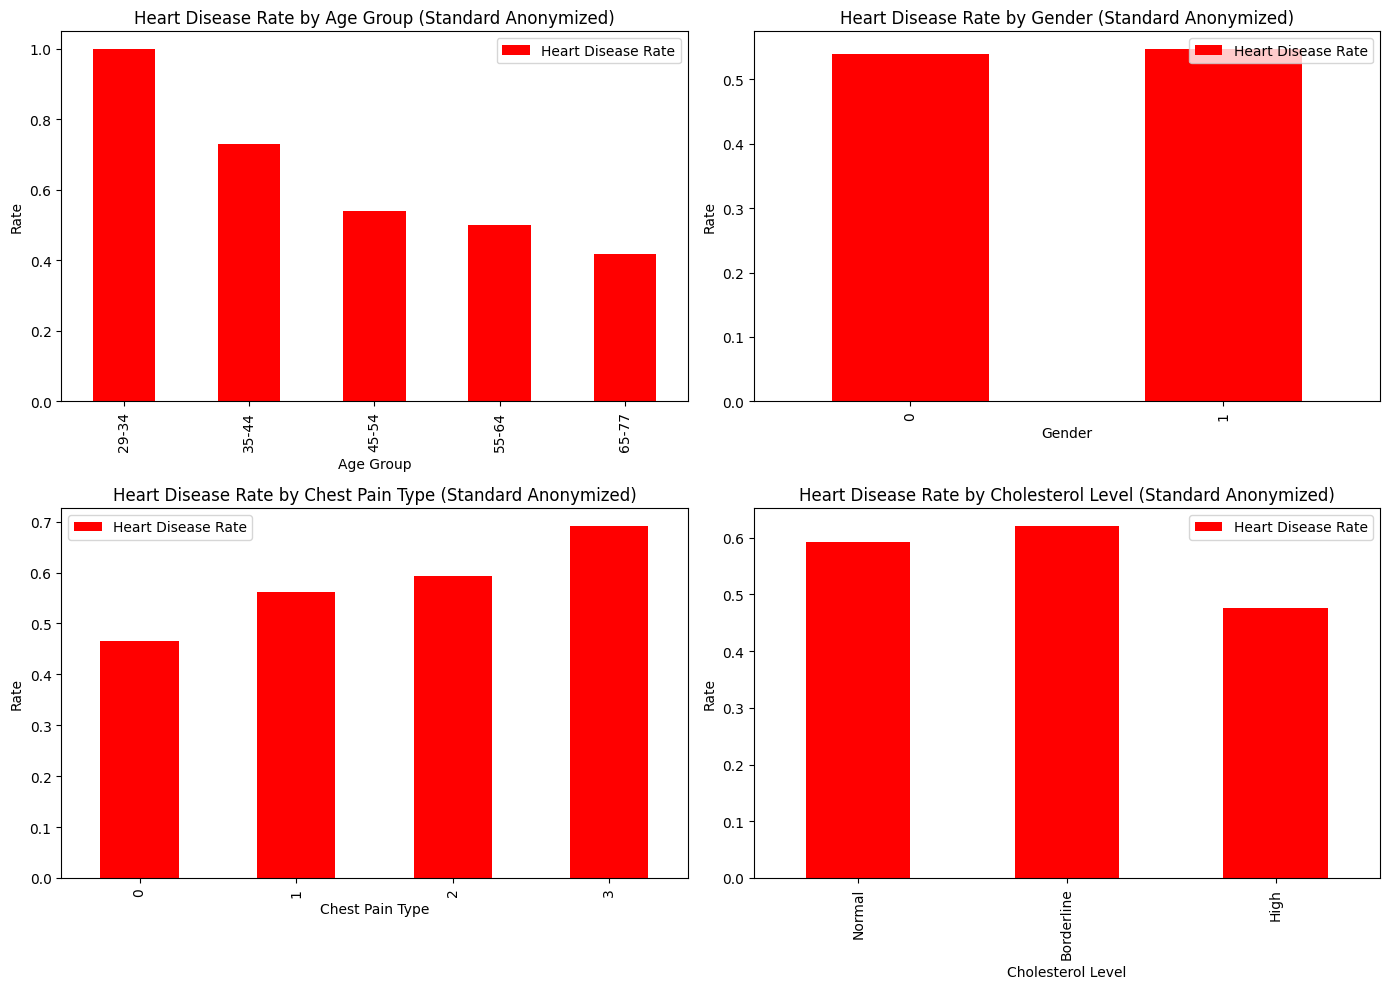

In [ ]:
# Analyze the standard anonymized dataset
anon_gen_df['age_group'] = pd.cut(anon_gen_df['age'], bins=bins, labels=labels)
anon_gen_df['chol_group'] = pd.cut(anon_gen_df['chol'], bins=[0, 200, 240, 600], labels=['Normal', 'Borderline', 'High'])

# 1. Age group
anon_age_stats = anon_gen_df.groupby('age_group')['target'].mean().reset_index()
anon_age_stats.columns = ['Age Group', 'Heart Disease Rate']

# 2. Gender
anon_gender_stats = anon_gen_df.groupby('sex')['target'].mean().reset_index()
anon_gender_stats.columns = ['Gender', 'Heart Disease Rate']
anon_gender_stats['Gender'] = anon_gender_stats['Gender'].map({0: '0', 1: '1'})

# 3. Chest pain type
anon_cp_stats = anon_gen_df.groupby('cp')['target'].mean().reset_index()
anon_cp_stats.columns = ['Chest Pain Type', 'Heart Disease Rate']

# 4. Cholesterol
anon_chol_stats = anon_gen_df.groupby('chol_group')['target'].mean().reset_index()
anon_chol_stats.columns = ['Cholesterol Level', 'Heart Disease Rate']

# Print statistics
print("\nHeart Disease Rate by Age Group:")
print(anon_age_stats)
print("\nHeart Disease Rate by Gender:")
print(anon_gender_stats)
print("\nHeart Disease Rate by Chest Pain Type:")
print(anon_cp_stats)
print("\nHeart Disease Rate by Cholesterol Level:")
print(anon_chol_stats)

# Calculate MAEs for standard anonymization
age_mae_std = np.mean(np.abs(pd.merge(orig_age_stats, anon_age_stats, on='Age Group')['Heart Disease Rate_x'] -
                            pd.merge(orig_age_stats, anon_age_stats, on='Age Group')['Heart Disease Rate_y']))
gender_mae_std = np.mean(np.abs(pd.merge(orig_gender_stats, anon_gender_stats, on='Gender')['Heart Disease Rate_x'] -
                               pd.merge(orig_gender_stats, anon_gender_stats, on='Gender')['Heart Disease Rate_y']))
cp_mae_std = np.mean(np.abs(pd.merge(orig_cp_stats, anon_cp_stats, on='Chest Pain Type')['Heart Disease Rate_x'] -
                           pd.merge(orig_cp_stats, anon_cp_stats, on='Chest Pain Type')['Heart Disease Rate_y']))
chol_mae_std = np.mean(np.abs(pd.merge(orig_chol_stats, anon_chol_stats, on='Cholesterol Level')['Heart Disease Rate_x'] -
                             pd.merge(orig_chol_stats, anon_chol_stats, on='Cholesterol Level')['Heart Disease Rate_y']))

print("\nMAE compared to original data:")
print(f"Age Group MAE: {age_mae_std:.4f}")
print(f"Gender MAE: {gender_mae_std:.4f}")
print(f"Chest Pain Type MAE: {cp_mae_std:.4f}")
print(f"Cholesterol Level MAE: {chol_mae_std:.4f}")
print(f"Average MAE: {np.mean([age_mae_std, gender_mae_std, cp_mae_std, chol_mae_std]):.4f}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
anon_age_stats.plot(x='Age Group', y='Heart Disease Rate', kind='bar', ax=axes[0,0], color='red')
axes[0,0].set_title('Heart Disease Rate by Age Group (Standard Anonymized)')
axes[0,0].set_ylabel('Rate')
anon_gender_stats.plot(x='Gender', y='Heart Disease Rate', kind='bar', ax=axes[0,1], color='red')
axes[0,1].set_title('Heart Disease Rate by Gender (Standard Anonymized)')
axes[0,1].set_ylabel('Rate')
anon_cp_stats.plot(x='Chest Pain Type', y='Heart Disease Rate', kind='bar', ax=axes[1,0], color='red')
axes[1,0].set_title('Heart Disease Rate by Chest Pain Type (Standard Anonymized)')
axes[1,0].set_ylabel('Rate')
anon_chol_stats.plot(x='Cholesterol Level', y='Heart Disease Rate', kind='bar', ax=axes[1,1], color='red')
axes[1,1].set_title('Heart Disease Rate by Cholesterol Level (Standard Anonymized)')
axes[1,1].set_ylabel('Rate')
plt.tight_layout()
plt.show()

## 3. Workload-Aware Anonymized Dataset Analysis

<ipython-input-16-868d6e11bfe3>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wa_age_stats = anon_groups_gen_df.groupby('age_group')['target'].mean().reset_index()
<ipython-input-16-868d6e11bfe3>:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wa_chol_stats = anon_groups_gen_df.groupby('chol_group')['target'].mean().reset_index()



Heart Disease Rate by Age Group:
  Age Group  Heart Disease Rate
0     29-34            0.571429
1     35-44            0.714286
2     45-54            0.626263
3     55-64            0.467742
4     65-77            0.333333

Heart Disease Rate by Gender:
  Gender  Heart Disease Rate
0      0            0.542373
1      1            0.545946

Heart Disease Rate by Chest Pain Type:
   Chest Pain Type  Heart Disease Rate
0                0            0.508772
1                1            0.580645
2                2            0.530864
3                3            0.666667

Heart Disease Rate by Cholesterol Level:
  Cholesterol Level  Heart Disease Rate
0            Normal            0.589286
1        Borderline            0.617021
2              High            0.483660

MAE compared to original data:
Age Group MAE: 0.0810
Gender MAE: 0.1521
Chest Pain Type MAE: 0.1917
Cholesterol Level MAE: 0.0049
Average MAE: 0.1074


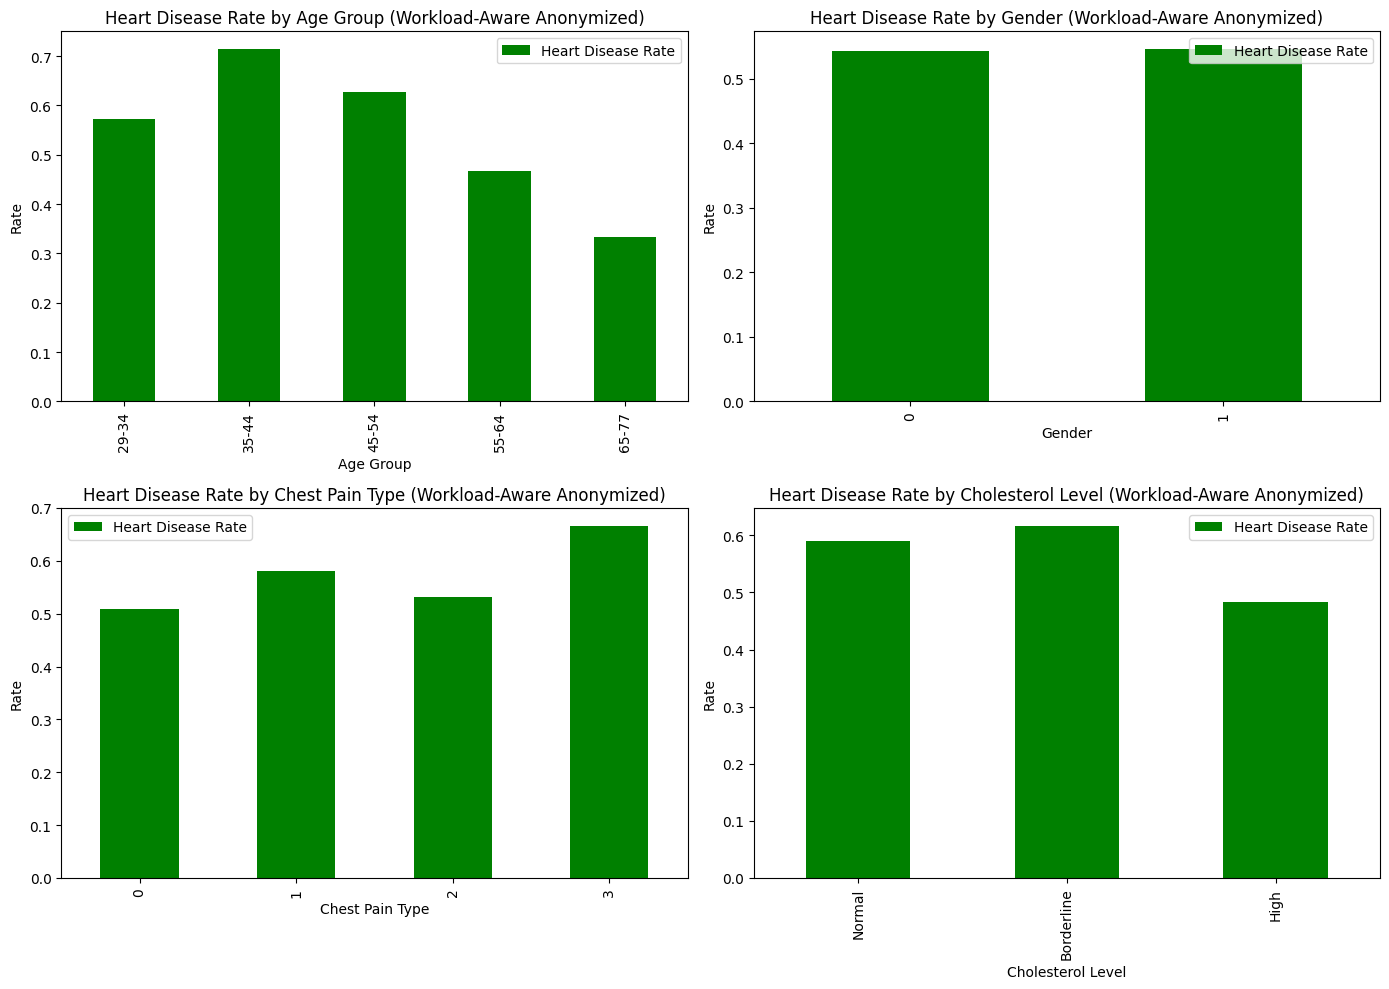

In [ ]:
# Analyze the workload-aware anonymized dataset
anon_groups_gen_df['age_group'] = pd.cut(anon_groups_gen_df['age'], bins=bins, labels=labels)
anon_groups_gen_df['chol_group'] = pd.cut(anon_groups_gen_df['chol'], bins=[0, 200, 240, 600], labels=['Normal', 'Borderline', 'High'])

# 1. Age group
wa_age_stats = anon_groups_gen_df.groupby('age_group')['target'].mean().reset_index()
wa_age_stats.columns = ['Age Group', 'Heart Disease Rate']

# 2. Gender
wa_gender_stats = anon_groups_gen_df.groupby('sex')['target'].mean().reset_index()
wa_gender_stats.columns = ['Gender', 'Heart Disease Rate']
wa_gender_stats['Gender'] = wa_gender_stats['Gender'].map({0: '0', 1: '1'})

# 3. Chest pain type
wa_cp_stats = anon_groups_gen_df.groupby('cp')['target'].mean().reset_index()
wa_cp_stats.columns = ['Chest Pain Type', 'Heart Disease Rate']

# 4. Cholesterol
wa_chol_stats = anon_groups_gen_df.groupby('chol_group')['target'].mean().reset_index()
wa_chol_stats.columns = ['Cholesterol Level', 'Heart Disease Rate']

# Print statistics
print("\nHeart Disease Rate by Age Group:")
print(wa_age_stats)
print("\nHeart Disease Rate by Gender:")
print(wa_gender_stats)
print("\nHeart Disease Rate by Chest Pain Type:")
print(wa_cp_stats)
print("\nHeart Disease Rate by Cholesterol Level:")
print(wa_chol_stats)

# Calculate MAEs for workload-aware anonymization
age_mae_wa = np.mean(np.abs(pd.merge(orig_age_stats, wa_age_stats, on='Age Group')['Heart Disease Rate_x'] -
                           pd.merge(orig_age_stats, wa_age_stats, on='Age Group')['Heart Disease Rate_y']))
gender_mae_wa = np.mean(np.abs(pd.merge(orig_gender_stats, wa_gender_stats, on='Gender')['Heart Disease Rate_x'] -
                              pd.merge(orig_gender_stats, wa_gender_stats, on='Gender')['Heart Disease Rate_y']))
cp_mae_wa = np.mean(np.abs(pd.merge(orig_cp_stats, wa_cp_stats, on='Chest Pain Type')['Heart Disease Rate_x'] -
                          pd.merge(orig_cp_stats, wa_cp_stats, on='Chest Pain Type')['Heart Disease Rate_y']))
chol_mae_wa = np.mean(np.abs(pd.merge(orig_chol_stats, wa_chol_stats, on='Cholesterol Level')['Heart Disease Rate_x'] -
                            pd.merge(orig_chol_stats, wa_chol_stats, on='Cholesterol Level')['Heart Disease Rate_y']))

print("\nMAE compared to original data:")
print(f"Age Group MAE: {age_mae_wa:.4f}")
print(f"Gender MAE: {gender_mae_wa:.4f}")
print(f"Chest Pain Type MAE: {cp_mae_wa:.4f}")
print(f"Cholesterol Level MAE: {chol_mae_wa:.4f}")
print(f"Average MAE: {np.mean([age_mae_wa, gender_mae_wa, cp_mae_wa, chol_mae_wa]):.4f}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
wa_age_stats.plot(x='Age Group', y='Heart Disease Rate', kind='bar', ax=axes[0,0], color='green')
axes[0,0].set_title('Heart Disease Rate by Age Group (Workload-Aware Anonymized)')
axes[0,0].set_ylabel('Rate')
wa_gender_stats.plot(x='Gender', y='Heart Disease Rate', kind='bar', ax=axes[0,1], color='green')
axes[0,1].set_title('Heart Disease Rate by Gender (Workload-Aware Anonymized)')
axes[0,1].set_ylabel('Rate')
wa_cp_stats.plot(x='Chest Pain Type', y='Heart Disease Rate', kind='bar', ax=axes[1,0], color='green')
axes[1,0].set_title('Heart Disease Rate by Chest Pain Type (Workload-Aware Anonymized)')
axes[1,0].set_ylabel('Rate')
wa_chol_stats.plot(x='Cholesterol Level', y='Heart Disease Rate', kind='bar', ax=axes[1,1], color='green')
axes[1,1].set_title('Heart Disease Rate by Cholesterol Level (Workload-Aware Anonymized)')
axes[1,1].set_ylabel('Rate')
plt.tight_layout()
plt.show()

In [ ]:
# Summary comparison
# Create a summary DataFrame to compare all three methods
summary_data = {
    'Statistic Group': ['Age Group', 'Gender', 'Chest Pain Type', 'Cholesterol Level'],
    'Standard Anonymization MAE': [age_mae_std, gender_mae_std, cp_mae_std, chol_mae_std],
    'Workload-Aware Anonymization MAE': [age_mae_wa, gender_mae_wa, cp_mae_wa, chol_mae_wa]
}

summary_df = pd.DataFrame(summary_data)
summary_df['Improvement (%)'] = ((summary_df['Standard Anonymization MAE'] -
                                 summary_df['Workload-Aware Anonymization MAE']) /
                                summary_df['Standard Anonymization MAE'] * 100)

print("\nSummary Comparison:")
display(summary_df)

# Calculate overall information preservation improvement
std_overall_mae = summary_df['Standard Anonymization MAE'].mean()
wa_overall_mae = summary_df['Workload-Aware Anonymization MAE'].mean()
improvement = (1 - wa_overall_mae/std_overall_mae) * 100

print(f"\nOverall Improvement: Workload-aware anonymization preserves {improvement:.2f}% more information than standard anonymization.")


Summary Comparison:


,Statistic Group,Standard Anonymization MAE,Workload-Aware Anonymization MAE,Improvement (%)
0,Age Group,0.131342,0.080961,38.358516
1,Gender,0.154135,0.152149,1.288593
2,Chest Pain Type,0.163766,0.191656,-17.030304
3,Cholesterol Level,0.002002,0.004877,-143.654436



Overall Improvement: Workload-aware anonymization preserves 4.79% more information than standard anonymization.


### Results discussion

For each dataset, we calculated the heart disease occurrence rate (percentage of patients with heart disease) across:

- **Age groups** (29–77 years, split into 5 groups)
- **Gender** (binary representation)
- **Chest pain types** (4 categories)
- **Cholesterol levels** (Normal, Borderline, High)

To quantify information loss from anonymization, we used Mean Absolute Error between the original statistics and each anonymized version's statistics.

### Key Findings

#### Age Group Analysis
- The **original dataset** shows variations in heart disease rates across age groups, with the highest rate (75.4%) in the 35–44 age group.
- The **standard anonymization** distorted this pattern (MAE: 0.1313), particularly overestimating the rate in the 29–34 group (100% vs. 66.7%).
- The **workload-aware** approach preserved this pattern much better (MAE: 0.0810), showing a **38.4% improvement** over standard anonymization.

#### Gender Analysis
- The **original dataset** shows heart disease is more widespread in gender category 0 (75.0%) compared to category 1 (44.9%). The **workload-aware** approach performed slightly better on this dimension (MAE: 0.1521) compared to **standard anonymization** (MAE: 0.1541), representing a **1.3% improvement**.

#### Chest Pain Type Analysis
- The **original dataset** shows variations in heart disease rates across different chest pain types (ranging from 27.3% to 82.0%). Both anonymization methods significantly distorted these patterns, though the **standard anonymization** approach performed slightly better (MAE: 0.1638 vs. 0.1917), representing a **17% worse performance** of the **workload-aware** approach.

#### Cholesterol Level Analysis
- For cholesterol levels, **both** methods preserved patterns relatively well, but the standard anonymization approach was remarkably accurate (MAE: 0.0020) compared to the **workload-aware** approach (MAE: 0.0049), representing a **144% worse performance** of the **workload-aware** approach. However, both approaches still were very close to the original data on this variable.


### Overall Comparison
The **workload-aware anonymization approach** preserves **4.79% more statistical information overall** compared to **standard anonymization**. It particularly excels at maintaining the relationships between age groups and gender heart disease rates, but performs worse for chest pain and cholestrol-based statistics.

This demonstrates that choosing the appropriate anonymization method depends on which demographic or clinical factors are most important for your specific analysis. If age groups and gender-related patterns are critical for your study, the workload-aware method would be strongly recommended, while for chest pain and cholestrol-based analysis, the standard method might be preferable.

# Exercise 3

The goal of this exercise is the same as before, but with a workload where the correlation between values is important.

We will be using the Life Expectancy Dataset. (https://www.kaggle.com/datasets/kumarajarshi/life-expectancy-who)

From this dataset we will be using the following attributes:

- Year: Year relevant to the tuple
- Status: If the country in the tuple is Developed or Developing
- Life expectancy: The life expectancy in age
- Adult Mortality: Mortality rates (Probability of dying between the age of 15 and 60 per 1000 population)
- Infant deaths: Number of infant deaths per 1000 population
- Alcohol: Alcohol comsuption per capita (in litres)
- Hepatitis B: Hepatitis B immunization coverage aming 1-year olds (percentage)
- Measles: Number of reported meales cases per 1000 population
- BMI: Average Body Mass Index of the population
- Total Expenditure: General Government expenditure on health, as a percentage of total government expenditure

From these attributes, we will be using the Life expectancy an the sensitive attribute, with the remaining attributes as quasi-identifiers

In [9]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Engineering_of_Data_Analysis/assignment1/Life_Expectancy_Data.csv')
data['Status'] = data['Status'].replace({'Developing': 0, 'Developed': 1})
sas = ['Life expectancy ']
qis = ['Year', 'Status', 'Alcohol', 'Hepatitis B', 'Measles ', ' BMI ', 'Total expenditure', 'Adult Mortality', 'infant deaths']
data = data.dropna()

<ipython-input-9-34bb07eae00e>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Status'] = data['Status'].replace({'Developing': 0, 'Developed': 1})


For anonymizing, keeping correlations, you can use the following code.

In [23]:
# Create workload-aware anonymization
# specify workload to preserve correlation between Adult Mortality and Life expectancy.
# Specifically, this bins/surpresses the quasi-identifiers while maintaining the
# correlation between Adult Mortality and Life Expectancy
corr_anon = anonymity.workload_aware_k_anonymity(data, qis, 5, queries=['corr(Adult Mortality, Life expectancy )'])
# Make workload-aware anonymization result more readable by showing absolute values instead of bins that respect the
# means/distribution of the original dataset but still anonymize it so the numbers shown are not necessarily the ones from the
# original dataset.
gen_corr = utility.generalize_intervals(corr_anon, qis, decimals=['Alcohol', 'BMI', 'Total expenditure'])

In [24]:
data.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,0,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,0,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,0,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,0,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,0,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [25]:
corr_anon.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Kiribati,2005 - 2014,0,66.1,1.0 - 2.0,0 - 364,0.01 - 2.25,97.871933,7.0 - 99.0,0 - 2981,...,79.0,1.21 - 8.83,75.0,0.1,1684.542740,11458.0,0.1,0.1,0.597,11.9
1,Pakistan,2005 - 2014,0,62.9,1.0 - 2.0,0 - 364,0.01 - 2.25,30.593208,7.0 - 99.0,0 - 2981,...,78.0,1.21 - 8.83,77.0,0.1,711.469946,15399667.0,21.2,21.7,0.487,6.1
2,Senegal,2005 - 2014,0,65.6,1.0 - 2.0,0 - 364,0.01 - 2.25,10.206595,7.0 - 99.0,0 - 2981,...,83.0,1.21 - 8.83,91.0,0.4,136.451800,1373513.0,1.0,9.9,0.463,8.3
3,Solomon Islands,2005 - 2014,0,67.6,1.0 - 2.0,0 - 364,0.01 - 2.25,28.901352,7.0 - 99.0,0 - 2981,...,93.0,1.21 - 8.83,9.0,0.1,146.931125,49294.0,1.2,1.2,0.482,9.0
4,Solomon Islands,2005 - 2014,0,67.6,1.0 - 2.0,0 - 364,0.01 - 2.25,240.485120,7.0 - 99.0,0 - 2981,...,99.0,1.21 - 8.83,99.0,0.1,948.659251,481422.0,1.3,1.3,0.470,8.4


In [26]:
gen_corr.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Kiribati,2012,0,66.1,2,111,1.517925,97.871933,25,1193,...,79.0,6.001309,75.0,0.1,1684.542740,11458.0,0.1,0.1,0.597,11.9
1,Pakistan,2005,0,62.9,2,306,0.018555,30.593208,15,1280,...,78.0,6.966456,77.0,0.1,711.469946,15399667.0,21.2,21.7,0.487,6.1
2,Senegal,2009,0,65.6,2,340,1.716434,10.206595,73,1187,...,83.0,7.612604,91.0,0.4,136.451800,1373513.0,1.0,9.9,0.463,8.3
3,Solomon Islands,2010,0,67.6,2,87,1.081301,28.901352,56,2962,...,93.0,5.720661,9.0,0.1,146.931125,49294.0,1.2,1.2,0.482,9.0
4,Solomon Islands,2005,0,67.6,2,151,0.186112,240.485120,24,674,...,99.0,7.002227,99.0,0.1,948.659251,481422.0,1.3,1.3,0.470,8.4


Compare the original dataset, the workload-aware anonymized dataset and the dataset anonymized with differential privacy for computing some form of regression.

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from diffprivlib.models import LinearRegression as DPLinearRegression

def plot_regression(X, y, model, label, color, linestyle='-', show_r2=True):
    y_pred = model.predict(X)
    plt.scatter(X, y, alpha=0.3, color='gray', label='Data')
    plt.plot(X, y_pred, color=color, linewidth=2, linestyle=linestyle,
             label=f'{label} (y = {model.intercept_:.2f} + {model.coef_[0]:.2f}x, R²={model.score(X, y):.2f})' if show_r2 else label)
    plt.xlabel('Adult Mortality')
    plt.ylabel('Life Expectancy')
    plt.legend()
    plt.grid(True)

## 1. Original Dataset Analysis

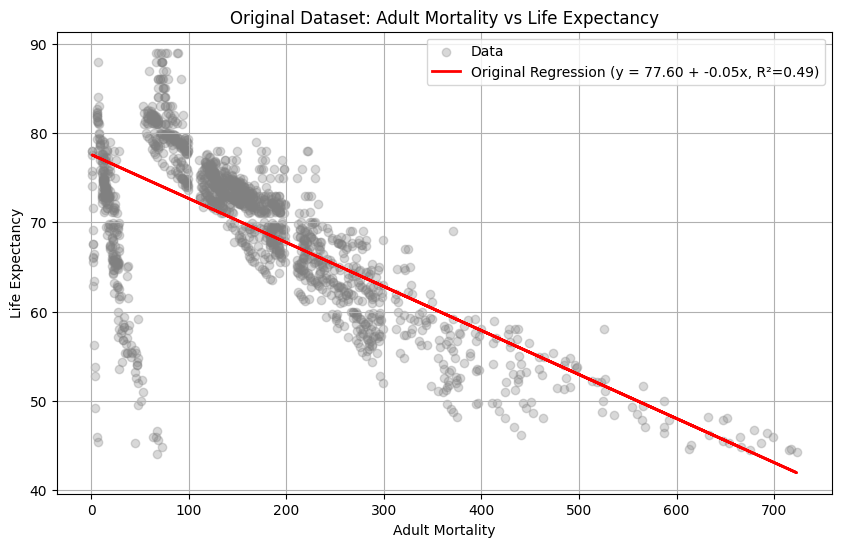

In [28]:
# TODO complete with code for original dataset
X_orig = data[['Adult Mortality']].values
y_orig = data['Life expectancy '].values
model_orig = LinearRegression().fit(X_orig, y_orig)
plt.figure(figsize=(10,6))
plot_regression(X_orig, y_orig, model_orig, 'Original Regression', 'red')
plt.title('Original Dataset: Adult Mortality vs Life Expectancy')
plt.show()

## 2. Workload-Aware Anonymized Dataset Analysis

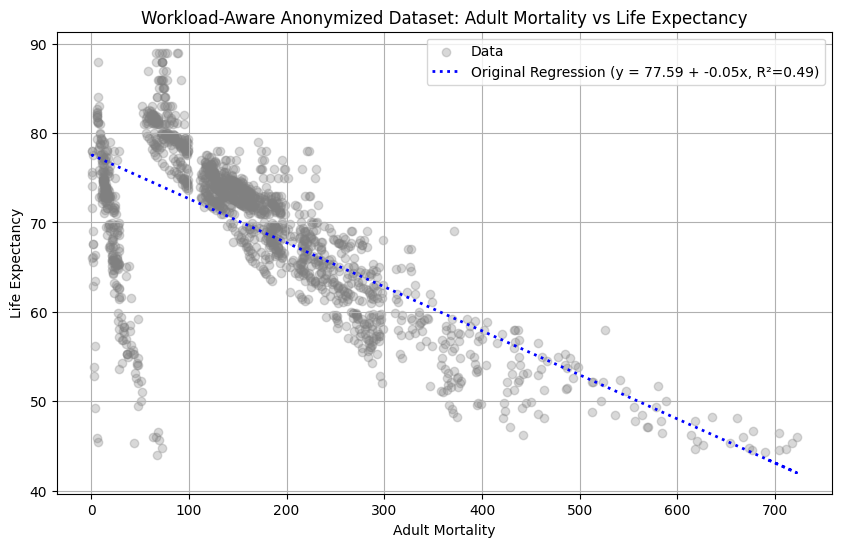

In [29]:
# TODO complete with code with workload-aware anonization
X_workload_aware = gen_corr[['Adult Mortality']].values
y_workload_aware = gen_corr['Life expectancy '].values
model_workload_aware = LinearRegression().fit(X_workload_aware, y_workload_aware)
plt.figure(figsize=(10,6))
plot_regression(X_workload_aware, y_workload_aware, model_workload_aware, 'Original Regression', 'blue', linestyle=":")
plt.title('Workload-Aware Anonymized Dataset: Adult Mortality vs Life Expectancy')
plt.show()

## 3. Differential Privacy Regression Analysis

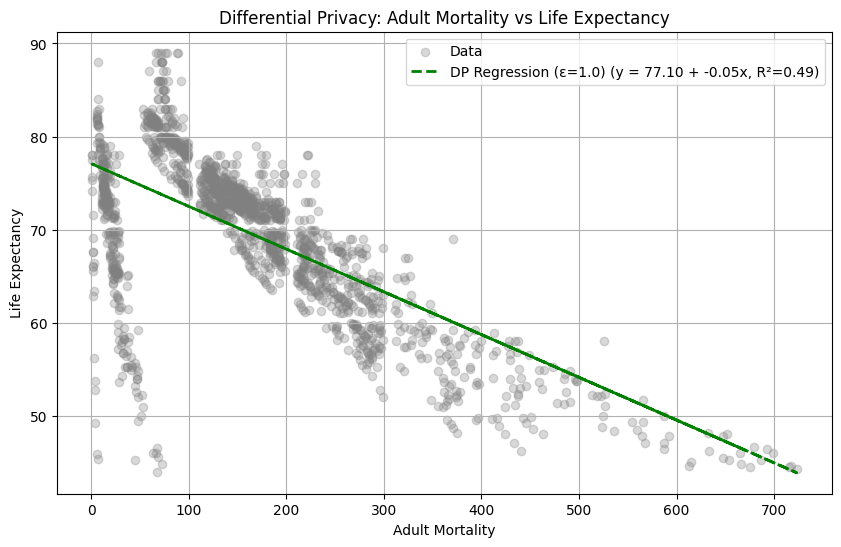

In [42]:
# TODO complete with code with differential privacy
X_dp = data[['Adult Mortality']].values
y_dp = data['Life expectancy '].values
# Instantiate the differentially private linear regression model
# the privacy parameter epsilon is set to 1
# Lower epsilon = more privacy, more noise, potentially lower accuracy
# Higher epsilon = less privacy, less noise, potentially higher accuracy
# Also, bounds are set on both Adult Mortality and Life expectancy
# We could just take the min and max values of both variables, and the
# model would automatically lower/raise all values above that value
# to the min/max values. However, as this would leak information
# about the min/max values, we instead use widely accepted
# values of adult mortality rates per 1000 and life expectancy
# based on general global health statistics ranges
# These are: 0 to 500 per 1000 adult mortality
# and age ranges of 20 to 100
dp_model = DPLinearRegression(epsilon=1.0,
                              bounds_X=(0, 750),
                              bounds_y=(20, 100))
dp_model.fit(X_dp, y_dp)
plt.figure(figsize=(10,6))
plot_regression(X_dp, y_dp, dp_model, 'DP Regression (ε=1.0)', 'green', linestyle='--')
plt.title('Differential Privacy: Adult Mortality vs Life Expectancy')
plt.show()

Text(0.5, 1.0, 'Comparison of Regression Models')

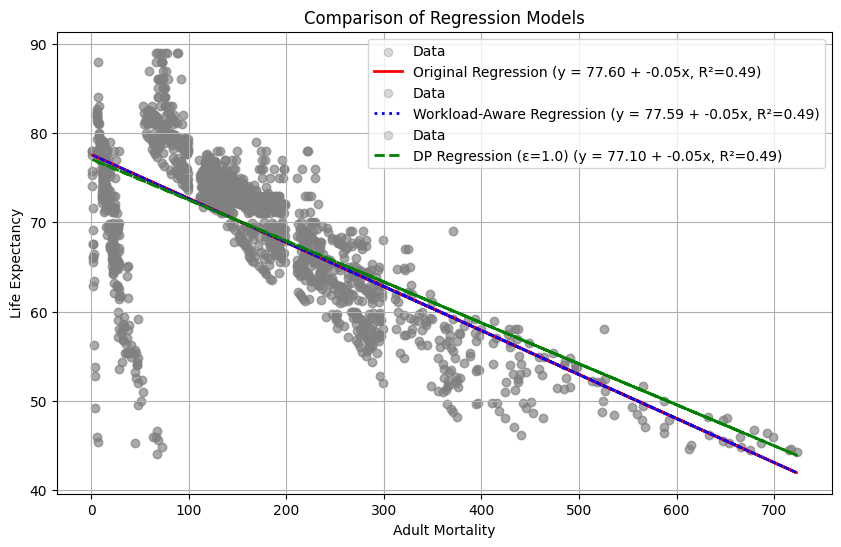

In [43]:
# Plotting all three regression lines together with original data points
# increase to ensure all three lines are visible
plt.figure(figsize=(10,6))
plot_regression(X_orig, y_orig, model_orig, 'Original Regression', 'red', linestyle="-", show_r2=True)
plot_regression(X_orig, y_orig, model_workload_aware, 'Workload-Aware Regression', 'blue', linestyle=":", show_r2=True)
plot_regression(X_orig, y_orig, dp_model, 'DP Regression (ε=1.0)', 'green', linestyle='--', show_r2=True)
plt.title('Comparison of Regression Models')

### Results discussion

### 1. Core finding  
Across all three modelling scenarios the link between **Adult Mortality** and **Life Expectancy** is negative, meaning a higher adult mortality correlates to a lower life expectancy in the dataset:

| Model | Intercept | Slope | R² |
|-------|-----------|-------|----|
| Original (no privacy) | 77.60 | –0.05 | 0.49 |
| Workload-aware k-anon (k = 5) | 77.58 | –0.05 | 0.49 |
| Differential Privacy (ε = 1.0) | 77.10 | –0.05 | 0.49 |

### 2. Workload-aware k-anonymity  
* The anonymization was explicitly tuned to keep the correlation `corr(Adult Mortality, Life expectancy)` intact.  
* Result: virtually **no change** in regression parameters or explanatory power (R²).  
* Interpretation: the generalisation of quasi-identifiers (intervals for Alcohol, BMI, etc.) provides privacy while safeguarding the analytical task of estimating mortality–life-expectancy trends.

### 3. Differentially-private regression  
* With ε = 1.0 and properly bounded features, the DP linear model also reproduces a regression line with **close to the same slope and R² as the one from the original data**.  
* The small shift in intercept **(≈0.5 years)** illustrates the noise added for privacy.  
* **Lower ε values** would increase this bias and could start to impact statistical validity.

### 4. Utility–privacy trade-off  
* k-anonymity (correlation-aware) gives **high utility** for the specified workload but may leak information through other, unprotected queries.  
* Differential Privacy offers **formal, query-agnostic privacy guarantees**; the observed utility is still high at ε = 1, yet scalability to multiple queries and smaller ε requires careful tuning.  

### 5. Take-away  
Both protection mechanisms can retain the epidemiologically meaningful relationship that higher adult mortality corresponds to lower life expectancy.  
• Choose workload-aware k-anonymity when the analysis tasks are known and limited.  
• Prefer Differential Privacy when broader, future-unknown queries or stronger privacy guarantees are needed, accepting some potential accuracy loss at lower ε.

## Exercise 4

The goal of this exercise is to compare results obtained with anonymized and non anonymized data for more complex ML techniques.

Repeat some code you have done in ML (or some other) course using the original dataset and an anonymization using differential privacy.


#### ML task performed

Briefly explain the task you are implementing:

The dataset used is a slightly altered version of [Telecom Churn Dataset](https://www.kaggle.com/datasets/mnassrib/telecom-churn-datasets). It consists of 2999 rows. Each row in the dataset represents one customer of the telcom company, with 19 features for each customer containing different attributes of that customer and a final column "Churn" as the label to predict.

The dataset is suitable for supervised machine learning as it is a binary classification task.

From this dataset we will be using the following attributes:

- Account length: how long the customer has been a customer at the telcom company (in days)
- Area Code: Area code of customer
- International plan: Whether the customer has an international plan (binary: 1 = yes)
- Voice mail plan: Whether the customer has a voice mail plan (binary: 1 = yes)
Number vmail messages: Number of voice mail messages of customer
- Total day charge: Amount customer was charged for day calls in the last year (in €)
- Total eve charge: Amount customer was charged for evening calls in the last year (in €)
- Total night charge: Amount customer was charged for night calls in the last year (in €)
- Total intl charge: Amount customer was charged for international calls in the last year (in €)
- Customer service calls: Nr of customer service calls of customer
- Churn: Did the customer churn or not (binary: 1 = yes)

From these attributes, we will run a logistic regresison of all of the attributes except Churn to predict Churn.

In [6]:
# Load the dataset
data_ml = pd.read_csv('/content/drive/MyDrive/churn_dataset.csv')
# Feature Selection
# Drop unnecessary columns
model_df = data_ml.drop(['Total eve calls', 'Total eve minutes', 'Total day calls', 'Total day minutes', 'Total night calls', 'Total night minutes', 'Total intl calls', 'Total intl minutes', 'State'], axis=1)
# Make categorical columns International Plan and Voice Mail Plan into binary columns with 1 for Yes and 0 for No, do the same for Churn
model_df['International plan'] = model_df['International plan'].map({'Yes': 1, 'No': 0})
model_df['Voice mail plan'] = model_df['Voice mail plan'].map({'Yes': 1, 'No': 0})
model_df['Churn'] = model_df['Churn'].astype(int)
model_df.head()

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day charge,Total eve charge,Total night charge,Total intl charge,Customer service calls,Churn
0,64,408,0,0,0,44.52,12.59,6.53,3.73,0,0
1,139,510,1,1,31,34.60,17.03,9.63,3.62,1,1
2,93,510,0,0,0,32.42,18.55,5.83,2.19,3,0
3,136,415,0,0,0,27.78,21.19,11.24,2.65,7,0
4,16,415,1,0,0,18.70,12.52,8.57,1.73,0,0


In [7]:
# parts of the ML pipeline that are the same for both the original data and
# differential privacy implementation.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Feature selection
X = model_df.drop('Churn', axis=1)
y = model_df['Churn']

# Train-test splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # Use the same scaler fitted on train data

# Check the shapes of the train and test sets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Check the distribution of the target variable in train and test sets to ensure that stratify=y worked
print(f"Churn rate in training set: {y_train.mean() * 100:.2f}%")
print(f"Churn rate in test set: {y_test.mean() * 100:.2f}%")

X_train shape: (2399, 10)
X_test shape: (600, 10)
y_train shape: (2399,)
y_test shape: (600,)
Churn rate in training set: 14.51%
Churn rate in test set: 14.50%


In [14]:
# TODO - code without differential privacy
# This is done with scikit-learn because my original code from the Machine
# Learning course was written with scikit-learn.
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Fitting the logistic regression model
print("\n--- Logistic Regression No Differential Privacy ---")
non_private_model = LogisticRegression(solver='liblinear', random_state=42)
non_private_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_non_private = non_private_model.predict(X_test_scaled)
y_pred_proba_non_private = non_private_model.predict_proba(X_test_scaled)[:, 1]

# Calculating ROC score and saving it to variable for comparison later
non_private_roc_auc = roc_auc_score(y_test, y_pred_proba_non_private)

# Evaluation
print("No Differential Privacy Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_non_private):.4f}")
print(f"AUC: {non_private_roc_auc:.4f}")
print(classification_report(y_test, y_pred_non_private))


--- Logistic Regression No Differential Privacy ---
No Differential Privacy Model Performance:
Accuracy: 0.8500
AUC: 0.7992
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       513
           1       0.45      0.16      0.24        87

    accuracy                           0.85       600
   macro avg       0.66      0.56      0.58       600
weighted avg       0.81      0.85      0.82       600



In [15]:
# TODO - code with differential privacy
import diffprivlib as dp
from diffprivlib.models import LogisticRegression

print("\n--- Differentially Private Logistic Regression (Diffprivlib) ---")

# DP Parameters for Diffprivlib
# Epsilon is the main privacy parameter here. Smaller epsilon = more privacy, likely lower accuracy.
# Data norm is an estimate of the maximum norm of a row in your scaled data. StandardScaler helps bound this.
dp_epsilon = 1.0
dp_data_norm = np.linalg.norm(X_train_scaled, axis=1).max() # Calculate max norm from training data

# Initialize DP Logistic Regression model
# Note: Diffprivlib's LogisticRegression has slightly different params than sklearn's
dp_model_diffprivlib = dp.models.LogisticRegression(
    epsilon=dp_epsilon,
    data_norm=dp_data_norm,
    max_iter=1000, # May need more iterations
    solver='lbfgs' # Common solver, others available
    # tol=1e-4 # Default tolerance
)

# Fitting the logistic regression model
print(f"Starting DP training with Epsilon={dp_epsilon}...")
dp_model_diffprivlib.fit(X_train_scaled, y_train)
print("DP training finished.")

# Predictions
y_pred_dp_diffprivlib = dp_model_diffprivlib.predict(X_test_scaled)
y_pred_proba_dp_diffprivlib = dp_model_diffprivlib.predict_proba(X_test_scaled)[:, 1]

# Privacy Guarantee (Epsilon is set directly)
print(f"\nDP Model Trained with Epsilon: {dp_model_diffprivlib.epsilon:.4f}")
# Delta is effectively 0 for the mechanism used in diffprivlib's logistic regression by default.

# Calculating ROC score and saving it to variable for comparison later
dp_roc_auc = roc_auc_score(y_test, y_pred_proba_dp_diffprivlib)

# Evaluation
print("\nDP Model Performance (Diffprivlib):")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dp_diffprivlib):.4f}")
print(f"AUC: {dp_roc_auc:.4f}")
print(classification_report(y_test, y_pred_dp_diffprivlib))


--- Differentially Private Logistic Regression (Diffprivlib) ---
Starting DP training with Epsilon=1.0...
DP training finished.

DP Model Trained with Epsilon: 1.0000

DP Model Performance (Diffprivlib):
Accuracy: 0.8267
AUC: 0.7496
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       513
           1       0.39      0.33      0.36        87

    accuracy                           0.83       600
   macro avg       0.64      0.62      0.63       600
weighted avg       0.82      0.83      0.82       600



/usr/local/lib/python3.11/dist-packages/diffprivlib/utils.py:71: DiffprivlibCompatibilityWarning: Parameter 'solver' is not functional in diffprivlib.  Remove this parameter to suppress this warning.
  warnings.warn(f"Parameter '{arg}' is not functional in diffprivlib.  Remove this parameter to suppress this "


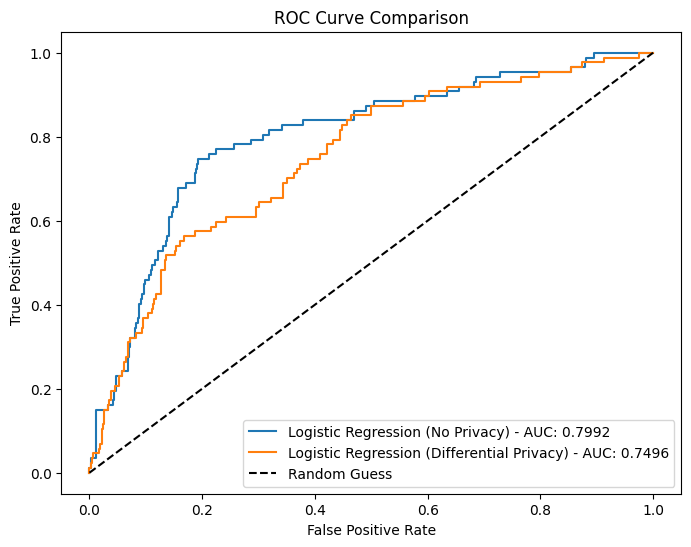

In [ ]:
# TODO - comparison of results
# Compare ROC curve of both models
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# ROC curve of logistic regression model with no
# anonymization
fpr_non_private, tpr_non_private, _ = roc_curve(y_test, y_pred_proba_non_private)

# ROC curve of logistic regression model with differential privacy
fpr_dp_diffprivlib, tpr_dp_diffprivlib, _ = roc_curve(y_test, y_pred_proba_dp_diffprivlib)

# Calculating ROC scores for both models


plt.figure(figsize=(8, 6))
plt.plot(fpr_non_private, tpr_non_private, label=f'Logistic Regression (No Privacy) - AUC: {non_private_roc_auc:.4f}')
plt.plot(fpr_dp_diffprivlib, tpr_dp_diffprivlib, label=f'Logistic Regression (Differential Privacy) - AUC: {dp_roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()

### Results discussion

**TO BE COMPLETED**
### 1. Overall Performance (AUC & Accuracy):

The non-private model achieved a higher overall performance, with an Accuracy of 0.8500 and an AUC of 0.7992.

The differentially private model showed a slight decrease in overall performance, with Accuracy dropping to 0.8267 (a decrease of ~2.3 percentage points) and AUC dropping more noticeably to 0.7496 (a decrease of ~0.05).

### 2. Class-Specific Performance (Precision, Recall, F1-Score):
This is where the impact of differential privacy becomes more nuanced, especially given the class imbalance (513 non-churners vs. 87 churners in the test set). Focusing specifically on the prediction of churners (as these are most relevant for a business because of customer acquisition cost)

Class 1 (Churn - Minority Class): This is often the critical class for business decisions.

The non-private model performed poorly on recall (0.16), meaning it only identified 16% of the actual churners. Its precision was modest (0.45). The resulting F1-score was very low (0.24).

The differentially private model showed a significant improvement in recall (0.33), identifying double the proportion of actual churners compared to the non-private model. This came at the cost of slightly lower precision (0.39).

Interestingly, the F1-score for the churn class improved substantially from 0.24 to 0.36 with the DP model. This indicates a better balance between precision and recall for the minority class, making the DP model arguably more useful for identifying churners despite its lower overall accuracy/AUC.

### 3. Discussion: The effect of differential privacy
As expected, introducing differential privacy (with Epsilon=1.0, representing a moderate level of privacy protection) resulted in a reduction in the model's overall predictive utility, as measured by accuracy and AUC. This is the fundamental trade-off: adding noise to protect individual data points makes it harder for the model to learn the exact patterns, leading to slightly lower performance.

The most interesting finding is the improved performance (Recall and F1-score) for the minority 'Churn' class in the DP model. While seemingly counter-intuitive, this can sometimes happen. The noise introduced by DP might act as a form of regularization, preventing the model from overfitting too heavily to the majority 'No Churn' class. This can allow the model to better capture the signal from the underrepresented churn examples, leading to higher recall.

**Practical Implications: The choice between these models depends on the goal.**

- If maximizing overall accuracy and the ability to rank customers by churn probability (AUC) is paramount, and privacy is not a concern, the standard model is better.

- However, if protecting customer privacy is necessary, and actually identifying a larger fraction of customers who are likely to churn (higher recall for Class 1) is more important than overall accuracy or minimizing false positives for churn, the differentially private model (at Epsilon=1.0) appears to be more effective in this specific scenario, despite the drop in AUC. It provides a privacy guarantee while improving the detection of the critical churn event.